# Morse Theory Primer

## Imports

In [2]:
import pyDOE
import ghalton
import itertools

# Visualization
import ipywidgets as widgets
from ipywidgets import interactive, fixed, interact
import matplotlib.pyplot as plt
from matplotlib import collections as mc
import seaborn as sns
import pandas as pd

# Custom Code
import topopy
import nglpy
import samplers
from test_functions import *

## Setup & Helper Functions

In [3]:
def highlight_edge(ax, X, i, j, color='#FFFFFF'):
    lines = [[(X[i, 0], X[i, 1]),
              (X[j, 0], X[j, 1])]]
    lc = mc.LineCollection(lines, colors=color, linewidths=2, linestyles='-', zorder=2)
    ax.add_collection(lc)
    return lc

def validation_grid(resolution=20, min_x = 0, max_x = 1):
    x, y = np.mgrid[min_x:max_x:(resolution * 1j), min_x:max_x:(resolution * 1j)]
    X = np.vstack([x.ravel(), y.ravel()]).T
    return x, y, X
    
def surface_plot(f, ax, resolution=50, samples=None, edges=None, title=None, cmap=plt.cm.cividis):
    min_x = 0
    max_x = 1
    
    x, y, X = validation_grid(resolution)
    Z = f(X)
    z = Z.reshape(x.shape)
    ax.contourf(x,y,z, cmap=cmap)
    
    if samples is not None:
        ax.scatter(samples[:, 0], samples[:, 1], s=80, linewidth=2, edgecolors="#FFFFFF", facecolors='none', zorder=2)
    if edges is not None:
        lines = []
        for edge in edges:
            lines.append([(samples[edge[0], 0], samples[edge[0], 1]),
                          (samples[edge[1], 0], samples[edge[1], 1])])
        lc = mc.LineCollection(lines, colors="#FFFFFF",
                               linewidths=1, linestyles='--', zorder=1)
        ax.add_collection(lc)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(title, fontsize=18)

def get_steepest_neighbor(X, f, edges, i):
    max_grad = 0
    max_neighbor = i
    for j in edges[i]:
        grad = (f(X[j]) - f(X[i])) / np.linalg.norm(X[j]-X[i])
        if grad > max_grad:
            max_grad = grad
            max_neighbor = j
    return max_neighbor
    

## From Theory To Practice: Consider a Discrete Sampling

In [4]:
########################################################################################################
# Parameters to potentially play with
resolution = 20
test_function = gerber
seed = 2
samples = 20
########################################################################################################

########################################################################################################
# setup Data
X = samplers.CVTSampler.generate_samples(samples, 2, seed)
X = np.vstack((X, np.array([[0.25,0.25], [0.25, 0.75], [0.75, 0.75]])))
Y = test_function(X)
########################################################################################################

########################################################################################################
# Setup reusable functions
def f(X):
    X = np.atleast_2d(X)
    Z = np.empty(X.shape[0])
    for i, xi in enumerate(X):
        Z[i] = test_function(xi)
    return Z

def fneg(X):
    X = np.atleast_2d(X)
    Z = np.empty(X.shape[0])
    for i, xi in enumerate(X):
        Z[i] = -test_function(xi)
    return Z
########################################################################################################
graph = nglpy.Graph(X, maxN=10, graph='relaxed beta skeleton', beta=1.0)

edges = graph.neighbors()
edge_set = set()
for i, neighbors in edges.items():
    for j in neighbors:
        lo, hi = min(i, j), max(i, j)
        edge_set.add((lo, hi))

def show_2d_test_function():
    ########################################################################################################
    # Setup Plots
    fig, ax = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(18, 9), dpi=200)
    ax = ax.flatten()
    fig.subplots_adjust(hspace=0)
    fig.tight_layout()
    ########################################################################################################
    
    surface_plot(f, ax[0], resolution=resolution, title='Smooth Function')
    surface_plot(f, ax[1], samples=X, resolution=resolution, title='Sampled Domain')
    surface_plot(f, ax[2], samples=X, edges=edge_set, resolution=resolution, title='Connected Domain')    

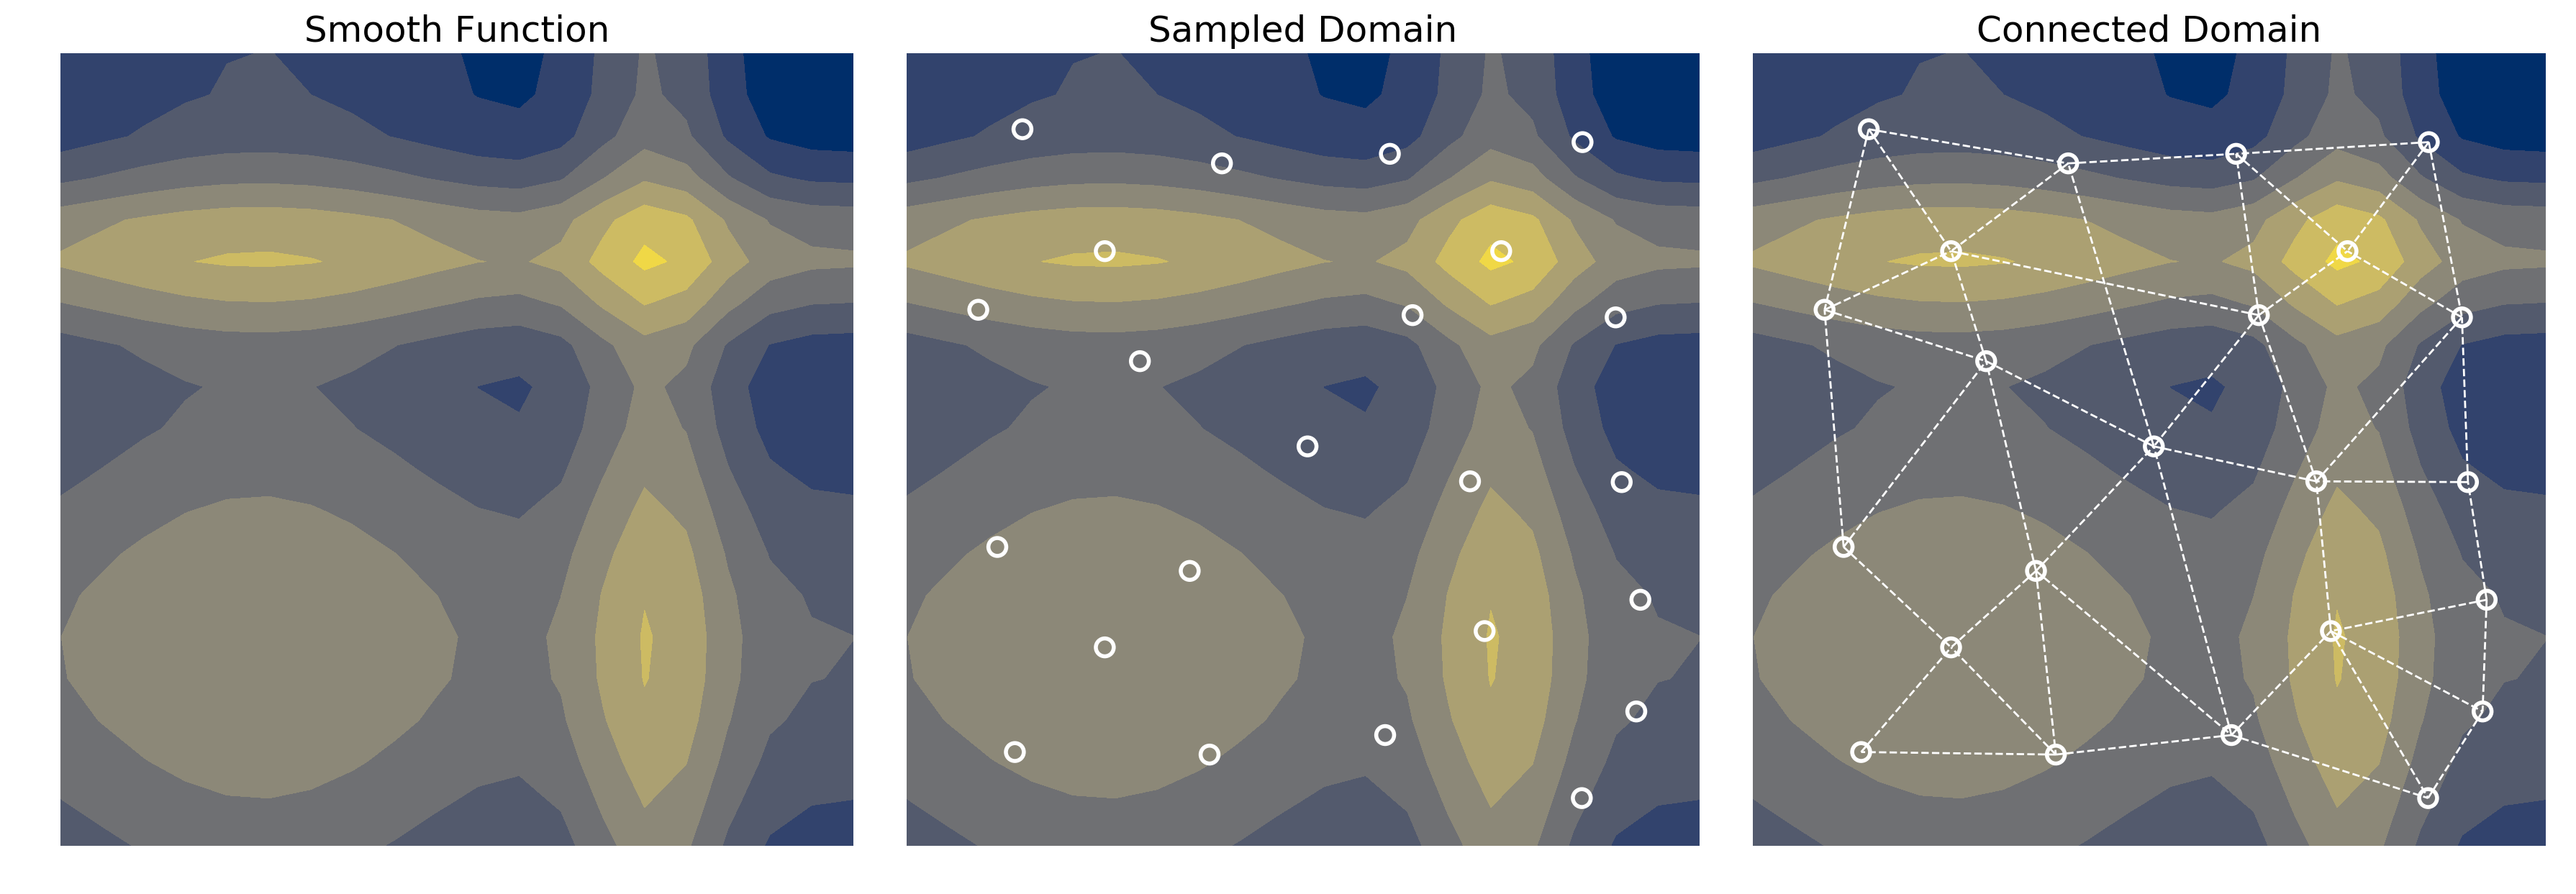

In [5]:
show_2d_test_function()

## Stable Manifolds Extraction from Discrete Samples

### Setup

In [8]:
def morse_decomposition(play, f):
    ########################################################################################################
    # Setup Plots
    fig, ax = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(3.5, 3.5), dpi=150)
    fig.subplots_adjust(hspace=0)
    fig.tight_layout()
    colors = itertools.cycle(['#8dd3c7','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69','#fccde5','#d9d9d9','#bc80bd','#ccebc5','#ffffb3','#ffed6f'])
    ########################################################################################################
    
    min_colors = {}
    
    edges = graph.neighbors()
    edge_set = set()
    for i, neighbors in edges.items():
        for j in neighbors:
            lo, hi = min(i, j), max(i, j)
            edge_set.add((lo, hi))

    steepest_paths = {}
    for i in range(len(X)):
        path = []
        j = get_steepest_neighbor(X, f, edges, i)
        last_item = i
        
        while j != last_item:
            path.append(j)
            last_item = j
            j = get_steepest_neighbor(X, f, edges, j)
        
        steepest_paths[i] = path
        
    surface_plot(f, ax, samples=X, edges=edge_set, resolution=resolution, title='Morse Complex Algorithm')
    step = 0
    while step < play:
        for i in range(len(X)):
            if i in min_colors:
                continue
                
            ax.scatter(X[i,0], X[i,1], s=80, linewidth=2, edgecolors="#000000", color='#FFFFFF', zorder=3)
            step += 1
            if step >= play:
                return
            last_item = i
            min_idx = i
            for j in steepest_paths[i]:
                if j not in min_colors:
                    ax.scatter(X[j,0], X[j,1], s=80, linewidth=2, edgecolors="#000000", color='#FFFFFF', zorder=3)
                    highlight_edge(ax, X, last_item, j)
                    last_item = j
                    step += 1
                    if step >= play:
                        return
            
            if len(steepest_paths[i]):
                min_idx = j
                
            if min_idx not in min_colors:
                min_colors[min_idx] = next(colors)
                ax.scatter(X[min_idx,0], X[min_idx,1], s=80, linewidth=2, edgecolors="#000000", color=min_colors[min_idx], zorder=3)
                step += 1
                if step >= play:
                    return
            ax.scatter(X[i,0], X[i,1], s=80, linewidth=2, edgecolors="#000000", color=min_colors[min_idx], zorder=3)
            last_item = i
            for j in steepest_paths[i]:
                min_colors[j] = min_colors[min_idx]
                ax.scatter(X[j,0], X[j,1], s=80, linewidth=2, edgecolors="#000000", color=min_colors[min_idx], zorder=3)
                highlight_edge(ax, X, last_item, j, min_colors[min_idx])
                last_item = j
            step += 1
            if step >= play:
                return
        return
    
stable_manifold = interactive(morse_decomposition, play=widgets.IntSlider(value=0, min=0, max=50, step=1), f=fixed(f))
unstable_manifold = interactive(morse_decomposition, play=widgets.IntSlider(value=0, min=0, max=43, step=1), f=fixed(fneg))

### Visualize

In [9]:
display(stable_manifold)

interactive(children=(IntSlider(value=0, description='play', max=50), Output()), _dom_classes=('widget-interac…

## Unstable Manifolds Extraction from Discrete Samples

In [23]:
display(unstable_manifold)

interactive(children=(IntSlider(value=0, description='play', max=43), Output()), _dom_classes=('widget-interac…

## Visualizing Persistence Simplification

### Setup

In [10]:
def saddle_extraction(play, f):
    ########################################################################################################
    # Setup Plots
    fig, ax = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(3.5, 3.5), dpi=150)
    fig.subplots_adjust(hspace=0)
    fig.tight_layout()
    colors = itertools.cycle(['#8dd3c7','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69','#fccde5','#d9d9d9','#bc80bd','#ccebc5','#ffffb3','#ffed6f'])
    ########################################################################################################
    
    ########################################################################################################
    # Parameters to potentially play with
    resolution = 20
    test_function = gerber
    seed = 0
    samples = 50
    ########################################################################################################

    ########################################################################################################
    # setup Data
    X = samplers.CVTSampler.generate_samples(samples, 2, seed)
    X = np.vstack((X, np.array([[0.25,0.25], [0.25, 0.75], [0.75, 0.25], [0.75, 0.75]])))
    Y = test_function(X)
    ########################################################################################################

    ########################################################################################################
    # Setup reusable functions
    def f(X):
        X = np.atleast_2d(X)
        Z = np.empty(X.shape[0])
        for i, xi in enumerate(X):
            Z[i] = test_function(xi)
        return Z

    def fneg(X):
        X = np.atleast_2d(X)
        Z = np.empty(X.shape[0])
        for i, xi in enumerate(X):
            Z[i] = -test_function(xi)
        return Z
    ########################################################################################################
    graph = nglpy.Graph(X, maxN=10, graph='relaxed beta skeleton', beta=1.0)
    
    min_colors = {}
    
    edges = graph.neighbors()
    edge_set = set()
    for i, neighbors in edges.items():
        for j in neighbors:
            lo, hi = min(i, j), max(i, j)
            edge_set.add((lo, hi))

    steepest_paths = {}
    for i in range(len(X)):
        path = []
        j = get_steepest_neighbor(X, f, edges, i)
        last_item = i
        
        while j != last_item:
            path.append(j)
            last_item = j
            j = get_steepest_neighbor(X, f, edges, j)
        
        steepest_paths[i] = path
        
    surface_plot(f, ax, samples=X, edges=edge_set, resolution=resolution, title='Saddle Extraction')
    for i in range(len(X)):
        min_idx = i
        if len(steepest_paths[i]):
            min_idx = steepest_paths[i][-1]
        if min_idx not in min_colors:
            min_colors[min_idx] = next(colors)
        ax.scatter(X[i,0], X[i,1], s=80, linewidth=2, edgecolors="#000000", color=min_colors[min_idx], zorder=3)
        last_item = i
        for j in steepest_paths[i]:
            min_colors[j] = min_colors[min_idx]
            ax.scatter(X[j,0], X[j,1], s=80, linewidth=2, edgecolors="#000000", color=min_colors[min_idx], zorder=3)
            last_item = j
        for j in edges[i]:
            min_j = steepest_paths[j][-1] if len(steepest_paths[j]) else j
            if min_idx == min_j:
                highlight_edge(ax, X, i, j, min_colors[min_idx])

    borders = {}
    for i, neighbors in edges.items():
        min_i = steepest_paths[i][-1] if len(steepest_paths[i]) else i
        for j in neighbors:
            min_j = steepest_paths[j][-1] if len(steepest_paths[j]) else j
            if min_i != min_j:
                lo, hi = min(min_i,min_j), max(min_i,min_j)
                if (lo, hi) not in borders:
                    borders[(lo, hi)] = set()

                lo2, hi2 = min(i,j), max(i,j)
                borders[(lo, hi)].add((lo2, hi2))
            
    step = 0
    if step >= play:
        return
    
    saddles = []
    persistences = []
    pairs = []
    for ext_pair, border_edges  in borders.items():
        highlighted_edges = []
        for e1, e2 in border_edges:
            highlighted_edges.append(highlight_edge(ax, X, e1, e2, '#FFFFFF'))
        step += 1
        if step >= play:
            return

        for lines in highlighted_edges:
            lines.remove()


        if f(X[ext_pair[0]]) < f(X[ext_pair[1]]):
            dying = ext_pair[0]
            surviving = ext_pair[1]
        else:
            dying = ext_pair[1]
            surviving = ext_pair[0]

        idxs = []
        for e1, e2 in border_edges:
            if e1 not in ext_pair:
                idxs.append(e1)
            if e2 not in ext_pair:
                idxs.append(e2)
        idxs = np.array(idxs)
        saddles.append(idxs[np.argmax(f(X[idxs]))])
        persistences.append(f(X[dying]) - f(X[saddles[-1]]))
        pairs.append((dying, surviving))

        ax.scatter(X[saddles,0], X[saddles,1], s=80, linewidth=2, edgecolors="#000000", color="#000000", zorder=3, marker='x')

        step += 1
        if step >= play:
            return
            
    pq = zip(persistences, saddles, pairs)
    pq = sorted(pq)
    
    saddle_annotations = []
    for i, (p, saddle, (dying, surviving)) in enumerate(pq):
        r = 0.05
        theta = i / len(pq) * 2*np.pi
        x_offset = r*np.cos(theta)
        y_offset = r*np.sin(theta)
        saddle_annotations.append(ax.annotate(s=str(i), xy=(X[saddle, 0]+x_offset, X[saddle, 1]+y_offset), color='#FFFFFF'))
    step += 1
    if step >= play:
        return
    
    dead = {}
    for (p, saddle, (dying, surviving)), annotation in zip(pq, saddle_annotations):
        if dying in dead:
            dying = dead[dying]
            
        for i in range(len(X)):
            if i == dying or (len(steepest_paths[i]) and steepest_paths[i][-1] == dying):
                min_idx = i
                if len(steepest_paths[i]):
                    min_idx = steepest_paths[i][-1]
                steepest_paths[i].append(surviving)
                min_colors[min_idx] = min_colors[surviving]
        for i in range(len(X)):
            min_i = i
            if len(steepest_paths[i]):
                min_i = steepest_paths[i][-1]
            ax.scatter(X[i,0], X[i,1], s=80, linewidth=2, edgecolors="#000000", color=min_colors[min_i], zorder=3)

        for i in range(len(X)):
            min_i = steepest_paths[i][-1] if len(steepest_paths[i]) else i
            for j in edges[i]:
                min_j = steepest_paths[j][-1] if len(steepest_paths[j]) else j
                if min_i == min_j:
                    highlight_edge(ax, X, i, j, min_colors[min_i])

        dead[dying] = surviving
        saddles.remove(saddle)
        annotation.remove()
        ax.scatter(X[saddles,0], X[saddles,1], s=80, linewidth=2, edgecolors="#000000", color="#000000", zorder=3, marker='x')
        step += 1
        if step >= play:
            return
    
persistence_algorithm = interactive(saddle_extraction, play=widgets.IntSlider(value=0, min=0, max=17, step=1), f=fixed(f))

### Visualize

In [11]:
display(persistence_algorithm)

interactive(children=(IntSlider(value=0, description='play', max=17), Output()), _dom_classes=('widget-interac…

# Adaptive Sampling with Topological Scores

## Imports

In [ ]:
# Computation
import numpy as np
import sklearn.gaussian_process
import pyDOE
import ghalton

# Visualization
import ipywidgets as widgets
from ipywidgets import interactive, fixed
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Custom Code
import topopy as tp
import samplers
from test_functions import *

# Debugging
import pdir
# import pixiedust

## Setup & Helper Functions

In [ ]:
def validation_grid(resolution=20, min_x = 0, max_x = 1):
    x, y = np.mgrid[min_x:max_x:(resolution * 1j), min_x:max_x:(resolution * 1j)]
    X = np.vstack([x.ravel(), y.ravel()]).T
    return x, y, X

def pretty_surface_plot(f, ax, resolution=50, train=None,
                        samples=None, title=None, cmap=plt.cm.gist_earth,
                        vmin=None, vmax=None):
    # ax.clear()
    min_x = 0
    max_x = 1
    
    
    x, y, X = validation_grid(resolution)
    Z = f(X)
    z = Z.reshape(x.shape)
    if vmin is None:
        vmin = min(Z)
    if vmax is None:
        vmax = max(Z)

    ax.contourf(x,y,z, cmap=cmap, vmin=vmin, vmax=vmax)
    
    if train is not None:
        # Hard-coding the initial training size here as 10
        ax.scatter(train[:10, 0], train[:10, 1], s=20, c=cmap(1.1), linewidth=1, edgecolors='#ffffff')
        if len(train) > 10:
            ax.scatter(train[10:, 0], train[10:, 1], s=40, c=cmap(1.1), linewidth=1, edgecolors='#ffffff')
    if samples is not None:
        # sample_colors = cmap((f(samples) - vmin)/(vmax-vmin))
        best_idx = np.argmax(f(samples))
        ax.scatter(samples[:, 0], samples[:, 1], s=20, linewidth=1, edgecolors="#FFFFFF", facecolors='none')
        ax.scatter(samples[best_idx, 0], samples[best_idx, 1], s=20, linewidth=4, edgecolors="#FFFFFF", facecolors='none')
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(title, fontsize=18)

def rms_error(error, resolution=20):
    x, y, X = validation_grid(resolution)    
    residuals = error(X)**2
    return np.sqrt(np.sum(residuals)) / len(X)

def extract_persistence_diagram(msc):
    dgm = []
    for line in msc.print_hierarchy().strip().split(' '):
        tokens = line.strip().split(',')
        extrema_type = tokens[0]
        p = float(tokens[1])
        idx = int(tokens[2])

        print(tokens)
        if token[0] == 'Minima':
            birth = Y[idx]
            death = Y[idx] + p
        else:
            birth = Y[idx] - p
            death = Y[idx]
        dgm.append((birth,death))

    return dgm

## Scoring Methods

In [ ]:
def closest_index(reference, query):
    idxs = np.empty(len(reference), dtype=int)
    for i, c in enumerate(reference):
        diff = (query - c)**2
        idxs[i] = np.argmin(np.sum(diff, axis=1))
    return idxs

def EI(model, train, candidates):
    x = train[:, :-1]
    y = train[:, -1]
    y_hat, σ = model.predict(candidates, return_std=True)
    idxs = closest_index(candidates, x)
    return (y_hat - y[idxs])**2 + σ**2

def Distance(model, train, candidates):
    x = train[:, :-1]
    y = train[:, -1]
    y_hat = model.predict(candidates)
    idxs = closest_index(candidates, x)
    return np.linalg.norm(x[idxs] - candidates, axis=1)

def Delta(model, train, candidates):
    x = train[:, :-1]
    y = train[:, -1]
    y_hat = model.predict(candidates)
    idxs = closest_index(candidates, x)
                            
    return np.abs(y[idxs] - y_hat)

def DP(model, train, candidates, score):
    return score(model, train, candidates) + Distance(model, train, candidates)

def ALM(model, train, candidates):
    return model.predict(candidates, return_std=True)[1]

def TopoB(model, train, candidates):
    extra_samples = samplers.CVTSampler.generate_samples(100, 2, 1)
    msc = tp.MorseSmaleComplex()
    msc.build(extra_samples, model.predict(extra_samples))
    dgm1 = extract_persistence_diagram(msc)
    
    scores = np.zeros(len(candidates))
    for xi in candidates:
        X = np.vstack((extra_samples, xi.reshape(1, -1)))
        test_msc = tp.MorseSmaleComplex()
        test_msc.build(X, model.predict(X))
        dgm2 = extract_persistence_diagram(test_msc)
        
        scores[i] = dionysus.bottleneck_distance(dgm1, dgm2)
        
    return scores

def TopoP(model, train, candidates):
    extra_samples = samplers.CVTSampler.generate_samples(100, 2, 2)
    msc = tp.MorseSmaleComplex()
    msc.build(extra_samples, model.predict(extra_samples))
    persistences = np.zeros(len(extra_samples)+1)
    sequence = msc.get_merge_sequence()
    for key, value in sequence.items():
        persistences[key] = value[0]
    
    scores = np.zeros(len(candidates))
    
    for i,xi in enumerate(candidates):
        X = np.vstack((extra_samples, xi.reshape(1, -1)))
        test_msc = tp.MorseSmaleComplex()
        test_msc.build(X, model.predict(X))
        test_persistences = np.zeros(len(X))
        sequence = msc.get_merge_sequence()
        for key, value in sequence.items():
            test_persistences[key] = value[0]
            
        scores[i] = np.sum(np.abs(persistences - test_persistences))
    
    return scores

def TopoHP(model, train, candidates):
    msc = tp.MorseSmaleComplex()
    X = np.vstack((train[:,:-1], candidates))
    Y = np.hstack((train[:,-1], model.predict(candidates)))
    msc.build(X, Y)
    scores = np.zeros(len(candidates))
    sequence = msc.get_merge_sequence()

    for key, (p, parent, saddle) in sequence.items():
        idx = key - len(train)
        if idx > 0:
            scores[idx] = p
    
    return scores

scoring_functions = {}
# for f in [ALM, EI, Delta, Distance, TopoB, TopoP, TopoHP]:
#     scoring_functions[f.__name__] = f
for f in [ALM, EI, Delta, Distance, TopoHP, TopoP]:
    scoring_functions[f.__name__] = f


## Adaptive Sampling Pipeline

In [ ]:
def surface_plot_sampling(strategy, play):
    ########################################################################################################
    # Parameters to potentially play with
    resolution = 20
    test_function = goldsteinPrice
    seed = 0
    model = sklearn.gaussian_process.GaussianProcessRegressor()
    ########################################################################################################
    
    ########################################################################################################
    # Setup Plots
    fig, ax = plt.subplots(1, 4, sharex='col', sharey='row', figsize=(18, 9), dpi=200)
    ax = ax.flatten()
#     error_ax = plt.subplot(2, 1, 2)
#     error_ax.set_xlabel('Training Size')
#     error_ax.set_ylabel('RMS Relative Error')
#     error_ax.set_xlim(10, 20)
    fig.subplots_adjust(hspace=0)
    fig.tight_layout()
    ########################################################################################################
    
    ########################################################################################################
    # setup Training Data
    np.random.seed(seed)
    train_x = pyDOE.lhs(2, 10)
    train_y = test_function(train_x)
    ########################################################################################################
    
    ########################################################################################################
    # setup Candidate Data
    candidate_x = samplers.CVTSampler.generate_samples(100, 2, seed)
    # candidate_x = pyDOE.lhs(2, 100)
    ########################################################################################################
    
    ########################################################################################################
    # Train the Surrogate
    model.fit(train_x, train_y)
    ########################################################################################################

    ########################################################################################################
    # Setup reusable functions
    def f(X):
        Z = np.empty(X.shape[0])
        for i, xi in enumerate(X):
            Z[i] = test_function(xi)
        return Z
    
    def f_hat(X):
        return model.predict(X)
    
    def error(X):
        return np.abs((f(X)-f_hat(X)) / f(X))
    
    def f_std(X):
        return model.predict(X, return_std=True)[1]
    
    def score(X):
        train = np.hstack((train_x, train_y.reshape(-1, 1)))
        return strategy(model, train, X)
    ########################################################################################################
    
    _, _, X = validation_grid(resolution)
    vmin = min(f(X))
    vmax = max(f(X))
    
    sizes = []
    errors = []
    sizes.append(len(train_x))
    errors.append(rms_error(error, resolution))
    for i in range(play):
        # Select best candidate
        best_idx = np.argmax(score(candidate_x))
        
        # Update training data and candidate set
        train_x = np.vstack((train_x, candidate_x[best_idx]))
        train_y = test_function(train_x)
        candidate_x = np.delete(candidate_x, best_idx, 0)
        
        # re-fit our surrogate
        model.fit(train_x, train_y)
        
        sizes.append(len(train_x))
        errors.append(rms_error(error, resolution))

    pretty_surface_plot(f,     ax[0], train=train_x,                      resolution=resolution, title='Ground Truth', cmap=plt.cm.Greens, vmin=vmin, vmax=vmax)
    pretty_surface_plot(f_hat, ax[1], train=train_x,                      resolution=resolution, title='Prediction', cmap=plt.cm.Oranges, vmin=vmin, vmax=vmax)
    pretty_surface_plot(error, ax[2], train=train_x,                      resolution=resolution, title='Error', cmap=plt.cm.Reds, vmin=0, vmax=1000)
    pretty_surface_plot(score, ax[3], train=train_x, samples=candidate_x, resolution=resolution, title='{} Score'.format(strategy.__name__), cmap=plt.cm.Blues)
#     if len(sizes) > 1:
#         error_ax.plot(sizes, errors)

adaptive_sampling_pipeline = interactive(surface_plot_sampling, strategy=scoring_functions, play=widgets.IntSlider(value=0, min=0, max=10, step=1))

In [ ]:
display(adaptive_sampling_pipeline)

In [ ]:
def show_results(test_function = goldsteinPrice):
    ########################################################################################################
    # Parameters to potentially play with
    resolution = 20
    model = sklearn.gaussian_process.GaussianProcessRegressor()
    rounds = 10
    repetitions = 2
    ########################################################################################################

    ########################################################################################################
    # Setup Plots
    fig, error_ax = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(8, 4), dpi=200)
    error_ax.set_xlabel('Training Size')
    error_ax.set_ylabel('RMS Relative Error')
    error_ax.set_xlim(10, 100)
    fig.subplots_adjust(hspace=0)
    fig.tight_layout()
    ########################################################################################################

    sizes = [range(10,10+rounds)]
    errors = pd.DataFrame(columns=['strategy', 'seed', 'size', 'error'])
    for name, strategy in scoring_functions.items():
        for seed in range(repetitions):
            ########################################################################################################
            # setup Training Data & Candidate Data
            np.random.seed(seed)
            train_x = pyDOE.lhs(2, 10)
            train_y = test_function(train_x)
            candidate_x = samplers.CVTSampler.generate_samples(100, 2, seed)
            ########################################################################################################

            ########################################################################################################
            # Train the Surrogate
            model.fit(train_x, train_y)
            ########################################################################################################

            ########################################################################################################
            # Setup reusable functions
            def f(X):
                Z = np.empty(X.shape[0])
                for i, xi in enumerate(X):
                    Z[i] = test_function(xi)
                return Z

            def f_hat(X):
                return model.predict(X)

            def error(X):
                return np.abs((f(X)-f_hat(X)) / f(X))

            def f_std(X):
                return model.predict(X, return_std=True)[1]

            def score(X):
                train = np.hstack((train_x, train_y.reshape(-1, 1)))
                return strategy(model, train, X)
            ########################################################################################################

            _, _, X = validation_grid(resolution)

            for i in range(rounds):
                errors = errors.append({'strategy': name,
                                        'seed': seed,
                                        'size': len(train_x),
                                        'error': rms_error(error, resolution)}, ignore_index=True)

                # Select best candidate
                best_idx = np.argmax(score(candidate_x))

                # Update training data and candidate set
                train_x = np.vstack((train_x, candidate_x[best_idx]))
                train_y = test_function(train_x)
                candidate_x = np.delete(candidate_x, best_idx, 0)

                # re-fit our surrogate
                model.fit(train_x, train_y)

    sns.pointplot(x='size', y='error', hue='strategy', data=errors)

## Performance Comparison

In [ ]:
show_results()

# Batch Sampling using Topology

# Structured Sensitivity Analysis

# Errors in Algorithm

# Deconstructing the Topology